In [1]:
import numpy as np
import pandas as pd

In [17]:
item_features = pd.read_csv('../data/item_features.csv')

In [4]:
features_agg = item_features.groupby(['item_id', 'feature_category_id']).size().reset_index().sort_values(0, ascending = False)
features_agg.rename(columns = {0: 'ct'}, inplace = True)
multi_value_features = features_agg[features_agg['ct'] > 1]['feature_category_id'].value_counts().reset_index()['feature_category_id'].tolist()
multi_value_features

[30, 4, 28, 53, 46, 1]

In [18]:
item_features['feature_category_id_proc'] = np.where(
    item_features['feature_category_id'].isin(multi_value_features),
    item_features['feature_category_id'].astype(str) + '-' + item_features['feature_value_id'].astype(str),
    item_features['feature_category_id']
)

item_features['feature_value_id_proc'] = np.where(
    item_features['feature_category_id'].isin(multi_value_features),
    1,
    item_features['feature_value_id']
)

In [19]:
item_features[item_features['feature_category_id'].isin([30, 2])]

item_id  feature_category_id  feature_value_id  \
129          10                   30               564   
134          10                   30               482   
153          11                   30               847   
154          11                   30               478   
156          11                   30               715   
...         ...                  ...               ...   
471561    28133                   30               194   
471590    28135                   30               564   
471593    28135                   30               478   
471597    28135                   30               482   
471680    28140                    2                53   

       feature_category_id_proc  feature_value_id_proc  
129                      30-564                      1  
134                      30-482                      1  
153                      30-847                      1  
154                      30-478                      1  
156                      30-715                      1  
...                         ...                    ...  
471561                   30-194                      1  
471590                   30-564                      1  
471593                   30-478                      1  
471597                   30-482                      1  
471680                        2                     53  

[17665 rows x 5 columns]

In [25]:
from xml.sax.handler import feature_external_ges


features_wide = item_features.pivot(index='item_id', columns = 'feature_category_id_proc', values = 'feature_value_id_proc').reset_index().fillna(0)
print(features_wide.shape)
features_wide

(23691, 172)


feature_category_id_proc  item_id     2      3      5    6      7    8    9  \
0                               2   0.0    0.0    0.0  0.0  394.0  0.0  0.0   
1                               3   0.0  889.0  605.0  0.0  452.0  0.0  0.0   
2                               4   0.0  793.0  605.0  0.0  837.0  0.0  0.0   
3                               7   0.0    0.0    0.0  0.0  536.0  0.0  0.0   
4                               8   0.0  793.0  605.0  0.0  798.0  0.0  0.0   
...                           ...   ...    ...    ...  ...    ...  ...  ...   
23686                       28139   0.0  793.0  605.0  0.0  798.0  0.0  0.0   
23687                       28140  53.0    0.0    0.0  0.0    0.0  0.0  0.0   
23688                       28141   0.0  889.0  605.0  0.0    2.0  0.0  0.0   
23689                       28142   0.0    0.0    0.0  0.0  619.0  0.0  0.0   
23690                       28143   0.0    0.0    0.0  0.0  798.0  0.0  0.0   

feature_category_id_proc   10     11  ...  4-865  46-71  46-783  46-825  \
0                         0.0    0.0  ...    0.0    0.0     0.0     0.0   
1                         0.0  859.0  ...    0.0    0.0     0.0     1.0   
2                         0.0    0.0  ...    0.0    0.0     0.0     1.0   
3                         0.0    0.0  ...    0.0    0.0     0.0     0.0   
4                         0.0  735.0  ...    0.0    0.0     0.0     1.0   
...                       ...    ...  ...    ...    ...     ...     ...   
23686                     0.0    0.0  ...    0.0    0.0     1.0     0.0   
23687                     0.0    0.0  ...    0.0    0.0     0.0     0.0   
23688                     0.0    0.0  ...    0.0    0.0     0.0     1.0   
23689                     0.0    0.0  ...    0.0    0.0     0.0     0.0   
23690                     0.0  109.0  ...    0.0    0.0     0.0     0.0   

feature_category_id_proc  46-882  53-155  53-444  53-6  53-680  53-707  
0                            0.0     0.0     0.0   1.0     0.0     0.0  
1                            0.0     0.0     0.0   0.0     0.0     0.0  
2                            0.0     0.0     0.0   0.0     0.0     0.0  
3                            0.0     0.0     0.0   0.0     0.0     0.0  
4                            0.0     0.0     0.0   0.0     0.0     0.0  
...                          ...     ...     ...   ...     ...     ...  
23686                        0.0     0.0     0.0   0.0     0.0     0.0  
23687                        0.0     0.0     0.0   0.0     0.0     0.0  
23688                        0.0     0.0     0.0   0.0     0.0     0.0  
23689                        0.0     0.0     0.0   0.0     0.0     0.0  
23690                        0.0     0.0     0.0   0.0     0.0     0.0  

[23691 rows x 172 columns]

Found 157 likely categorical and 15 likely continuous features


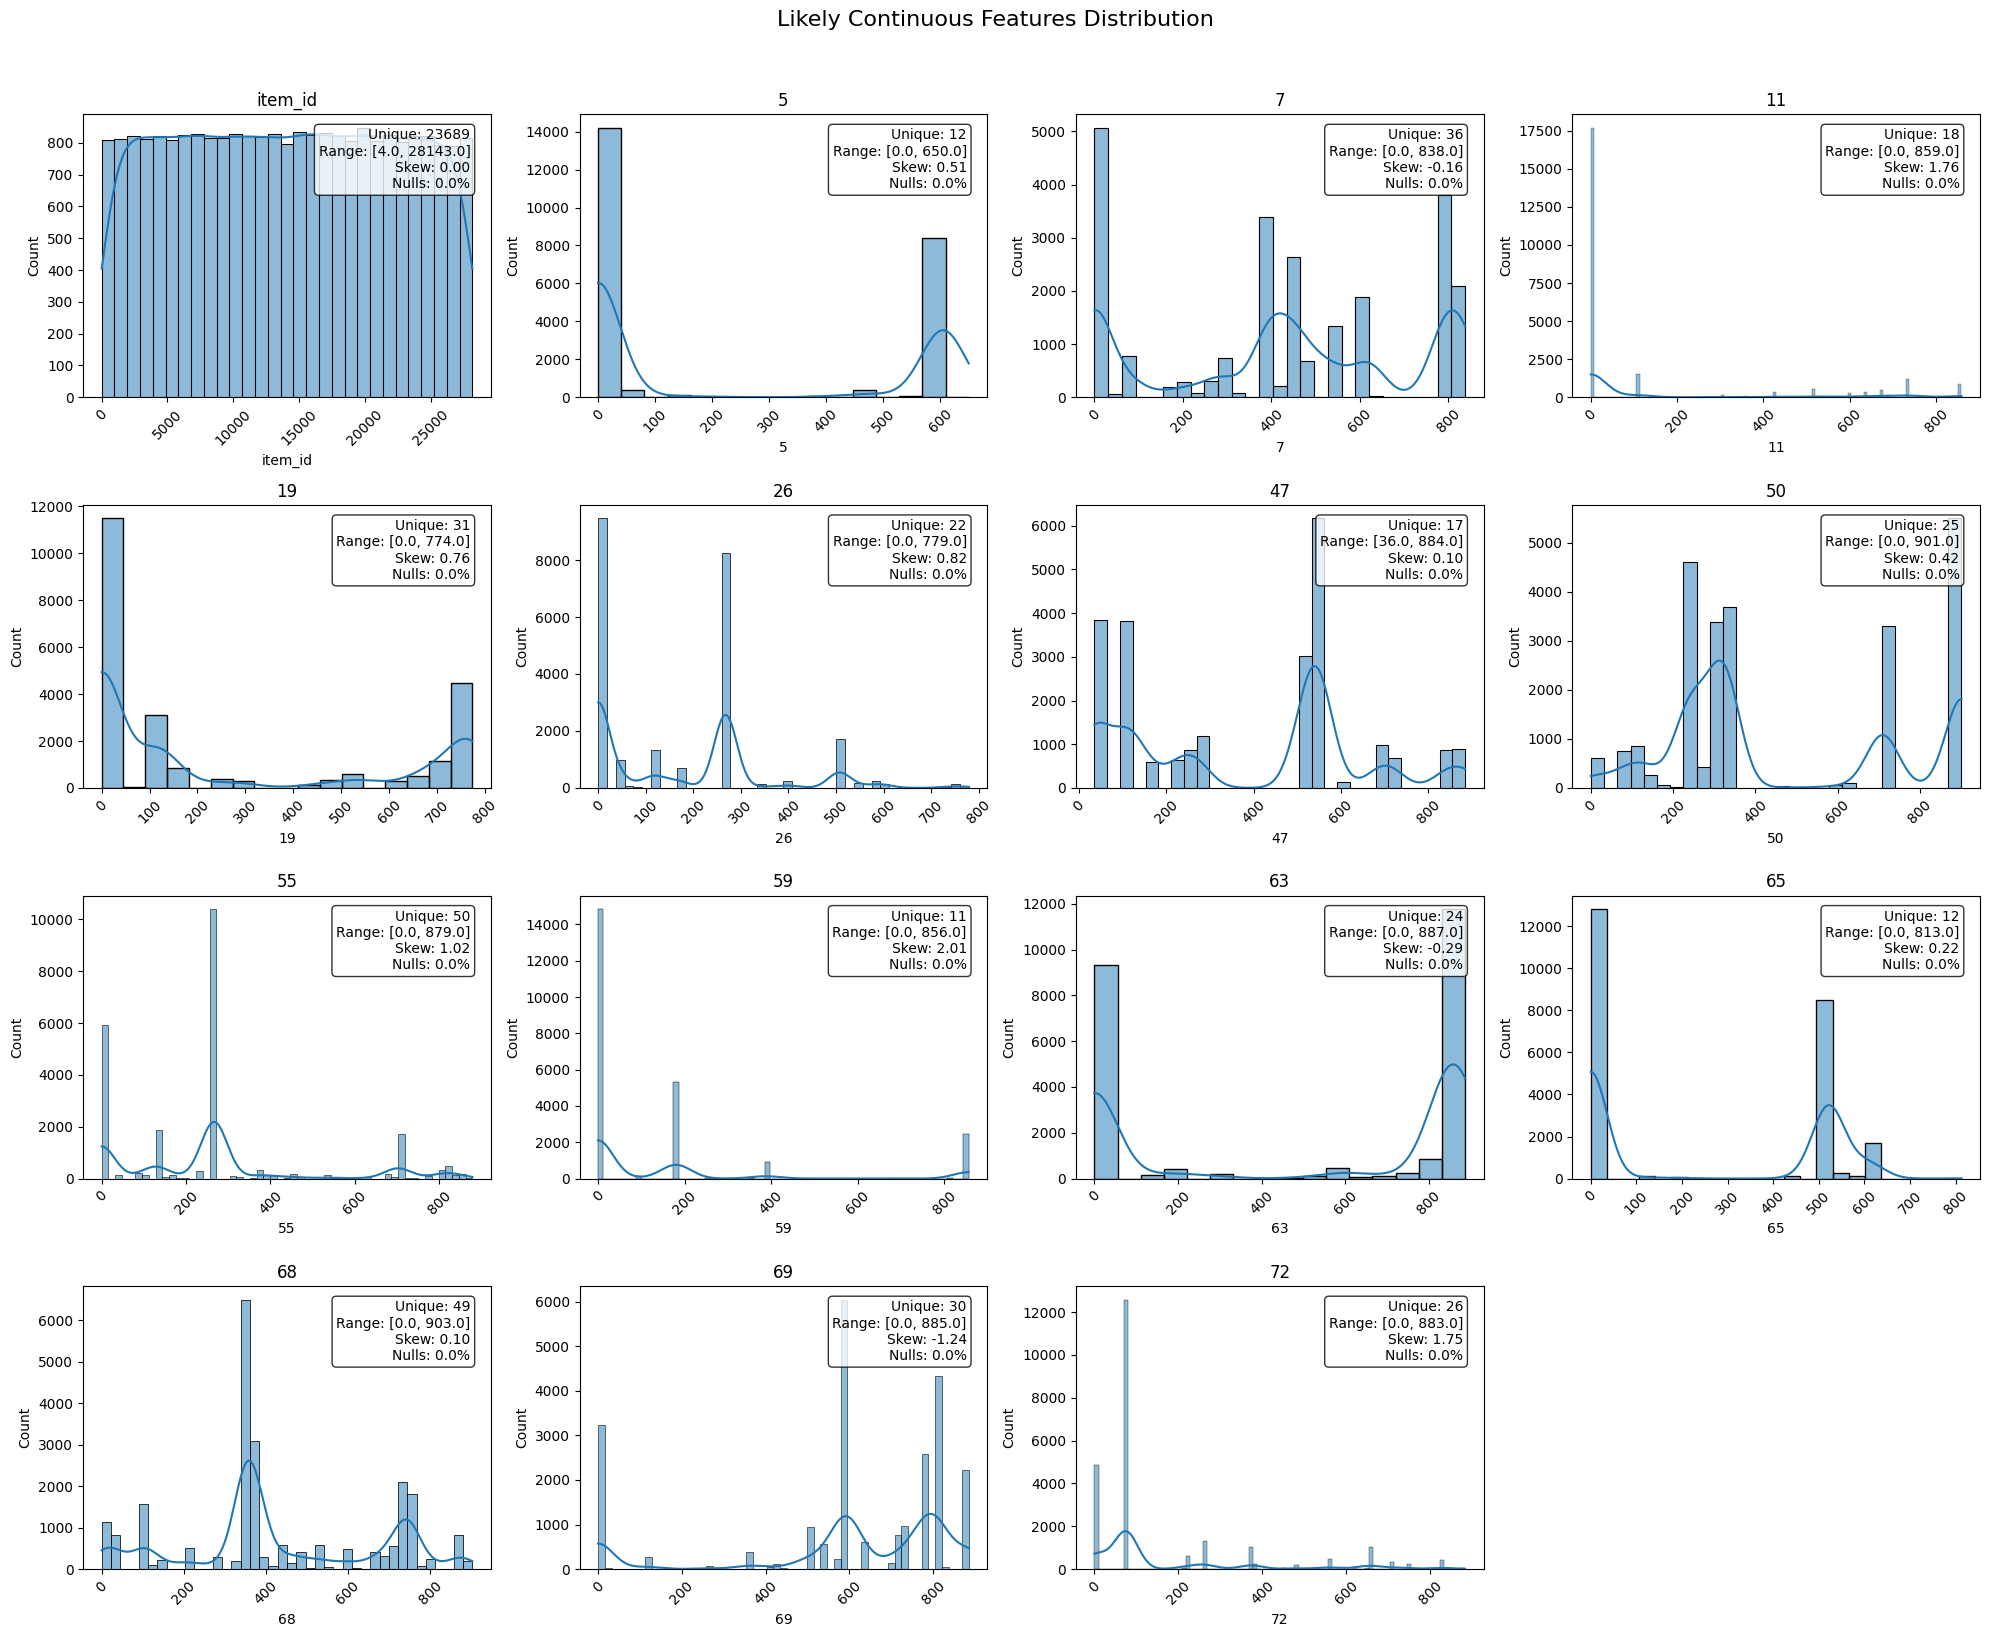

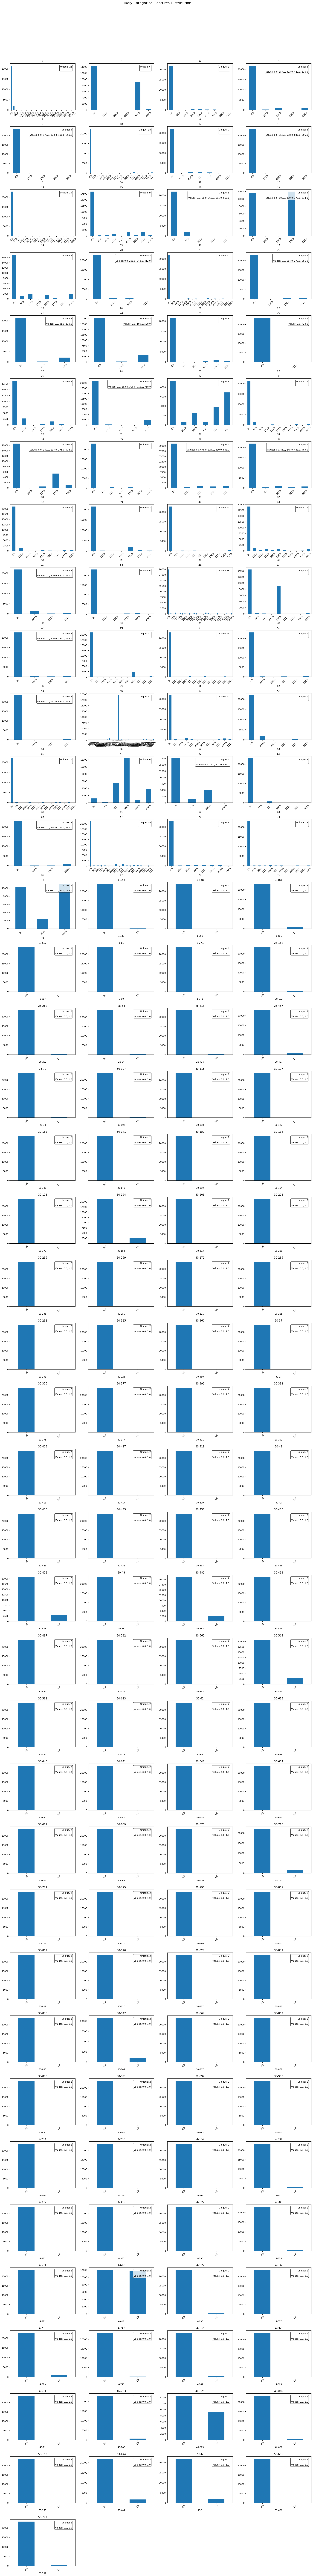

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

def analyze_numerical_features(df):
    """
    Analyzes numerical features and attempts to classify them as categorical or continuous
    based on their distribution characteristics.
    
    Args:
        df: pandas DataFrame with numerical features as columns
    """
    #plt.style.use('seaborn')
    
    def classify_numerical_feature(series):
        """
        Classifies a numerical feature as categorical or continuous based on:
        1. Number of unique values
        2. Gaps in the distribution
        3. Distribution shape metrics (kurtosis, etc.)
        """
        # Remove nulls for analysis
        clean_series = series.dropna()
        n_unique = clean_series.nunique()
        n_samples = len(clean_series)
        
        # Strong indicators of categorical:
        # 1. Very few unique values relative to sample size
        if n_unique <= min(10, n_samples * 0.01):
            return 'categorical'
            
        # 2. Large gaps in sorted values suggesting discrete categories
        sorted_vals = np.sort(clean_series.unique())
        if len(sorted_vals) > 1:
            gaps = np.diff(sorted_vals)
            max_gap = np.max(gaps)
            mean_gap = np.mean(gaps)
            if max_gap > mean_gap * 5 and n_unique < 50:  # Large gaps and not too many unique values
                return 'categorical'
        
        # 3. High kurtosis suggesting peaks at specific values
        if stats.kurtosis(clean_series) > 5 and n_unique < 100:
            return 'categorical'
            
        return 'continuous'
    
    # Analyze each column
    feature_types = {}
    null_percentages = {}
    
    for col in df.columns:
        null_percentages[col] = (df[col].isnull().sum() / len(df)) * 100
        feature_types[col] = classify_numerical_feature(df[col])
    
    categorical_features = [col for col, type_ in feature_types.items() if type_ == 'categorical']
    continuous_features = [col for col, type_ in feature_types.items() if type_ == 'continuous']
    
    print(f"Found {len(categorical_features)} likely categorical and {len(continuous_features)} likely continuous features")
    
    # Plot continuous features
    if continuous_features:
        n_cols = 4
        n_rows = int(np.ceil(len(continuous_features) / n_cols))
        fig_height = 4 * n_rows
        
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, fig_height))
        fig.suptitle('Likely Continuous Features Distribution', fontsize=16, y=1.02)
        
        if n_rows == 1:
            axes = axes.reshape(1, -1)
        
        for idx, feature in enumerate(continuous_features):
            row = idx // n_cols
            col = idx % n_cols
            ax = axes[row, col]
            
            values = df[feature].dropna()
            
            # Create histogram with KDE for continuous features
            sns.histplot(data=values, kde=True, ax=ax)
            
            # Add feature stats
            stats_text = f'Unique: {values.nunique()}\n'
            stats_text += f'Range: [{values.min():.1f}, {values.max():.1f}]\n'
            stats_text += f'Skew: {stats.skew(values):.2f}\n'
            stats_text += f'Nulls: {null_percentages[feature]:.1f}%'
            
            ax.text(0.95, 0.95, stats_text,
                   transform=ax.transAxes,
                   verticalalignment='top',
                   horizontalalignment='right',
                   bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
            
            ax.set_title(feature)
            ax.tick_params(axis='x', rotation=45)
        
        # Remove empty subplots
        for idx in range(len(continuous_features), n_rows * n_cols):
            row = idx // n_cols
            col = idx % n_cols
            fig.delaxes(axes[row, col])
        
        plt.tight_layout()
    
    # Plot categorical-like features
    if categorical_features:
        n_cols = 4
        n_rows = int(np.ceil(len(categorical_features) / n_cols))
        fig_height = 4 * n_rows
        
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, fig_height))
        fig.suptitle('Likely Categorical Features Distribution', fontsize=16, y=1.02)
        
        if n_rows == 1:
            axes = axes.reshape(1, -1)
        
        for idx, feature in enumerate(categorical_features):
            row = idx // n_cols
            col = idx % n_cols
            ax = axes[row, col]
            
            # For categorical-like features, plot value counts
            value_counts = df[feature].value_counts().sort_index()
            null_count = df[feature].isnull().sum()
            
            value_counts.plot(kind='bar', ax=ax)
            
            # Add feature stats
            stats_text = f'Unique: {df[feature].nunique()}\n'
            if null_count > 0:
                stats_text += f'Nulls: {null_percentages[feature]:.1f}%\n'
            
            # Show actual values for small number of categories
            if len(value_counts) <= 5:
                values_text = '\nValues: ' + ', '.join(f'{v:.1f}' for v in sorted(value_counts.index))
                stats_text += values_text
            
            ax.text(0.95, 0.95, stats_text,
                   transform=ax.transAxes,
                   verticalalignment='top',
                   horizontalalignment='right',
                   bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
            
            ax.set_title(feature)
            ax.tick_params(axis='x', rotation=45)
        
        # Remove empty subplots
        for idx in range(len(categorical_features), n_rows * n_cols):
            row = idx // n_cols
            col = idx % n_cols
            fig.delaxes(axes[row, col])
        
        plt.tight_layout()
    
    return {
        'categorical_features': categorical_features,
        'continuous_features': continuous_features,
        'null_percentages': null_percentages,
        'feature_types': feature_types
    }

# Example usage:
if __name__ == "__main__":
    
    df = features_wide.iloc[2:]
    
    # Run analysis
    results = analyze_numerical_features(df)
    plt.show()

In [31]:
[k for k in results.keys()]

['categorical_features',
 'continuous_features',
 'null_percentages',
 'feature_types']

In [32]:
results['feature_types']

{'item_id': 'continuous',
 2: 'categorical',
 3: 'categorical',
 5: 'continuous',
 6: 'categorical',
 7: 'continuous',
 8: 'categorical',
 9: 'categorical',
 10: 'categorical',
 11: 'continuous',
 12: 'categorical',
 13: 'categorical',
 14: 'categorical',
 15: 'categorical',
 16: 'categorical',
 17: 'categorical',
 18: 'categorical',
 19: 'continuous',
 20: 'categorical',
 21: 'categorical',
 22: 'categorical',
 23: 'categorical',
 24: 'categorical',
 25: 'categorical',
 26: 'continuous',
 27: 'categorical',
 29: 'categorical',
 31: 'categorical',
 32: 'categorical',
 33: 'categorical',
 34: 'categorical',
 35: 'categorical',
 36: 'categorical',
 37: 'categorical',
 38: 'categorical',
 39: 'categorical',
 40: 'categorical',
 41: 'categorical',
 42: 'categorical',
 43: 'categorical',
 44: 'categorical',
 45: 'categorical',
 47: 'continuous',
 48: 'categorical',
 49: 'categorical',
 50: 'continuous',
 51: 'categorical',
 52: 'categorical',
 54: 'categorical',
 55: 'continuous',
 56: 'cat

In [35]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import pandas as pd
import numpy as np

def create_preprocessing_pipeline(categorical_features, continuous_features):
    """
    Creates a preprocessing pipeline that handles both categorical and continuous features.
    
    Args:
        categorical_features: List of column names for categorical features
        continuous_features: List of column names for continuous features
        
    Returns:
        Pipeline object and list of feature names after transformation
    """
    # Create transformers for each type of feature
    categorical_transformer = Pipeline([
        ('onehot', OneHotEncoder(handle_unknown='ignore', 
                                sparse_output=False,
                                drop=None))  # don't drop any category to preserve NULL encoding
    ])

    continuous_transformer = Pipeline([
        ('scaler', StandardScaler())
    ])

    # Combine transformers into a ColumnTransformer
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', continuous_transformer, continuous_features),
            ('cat', categorical_transformer, categorical_features)
        ],
        remainder='drop'  # drop any columns not specified in features
    )

    # Create the full pipeline
    full_pipeline = Pipeline([
        ('preprocessor', preprocessor)
    ])
    
    return full_pipeline

def get_feature_names(pipeline, categorical_features, continuous_features):
    """
    Gets the feature names after transformation.
    
    Args:
        pipeline: Fitted pipeline object
        categorical_features: Original categorical feature names
        continuous_features: Original continuous feature names
    
    Returns:
        List of feature names after transformation
    """
    # Get the column transformer
    column_transformer = pipeline.named_steps['preprocessor']
    
    # Get feature names from each transformer
    feature_names = []
    
    # Add continuous feature names (these stay the same, just scaled)
    feature_names.extend(continuous_features)
    
    # Add categorical feature names (these are expanded into one-hot columns)
    cat_encoder = column_transformer.named_transformers_['cat'].named_steps['onehot']
    cat_features = []
    for i, feature in enumerate(categorical_features):
        cats = cat_encoder.categories_[i]
        for cat in cats:
            cat_features.append(f"{feature}_{cat}")
    feature_names.extend(cat_features)
    
    return feature_names

Found 157 likely categorical and 15 likely continuous features


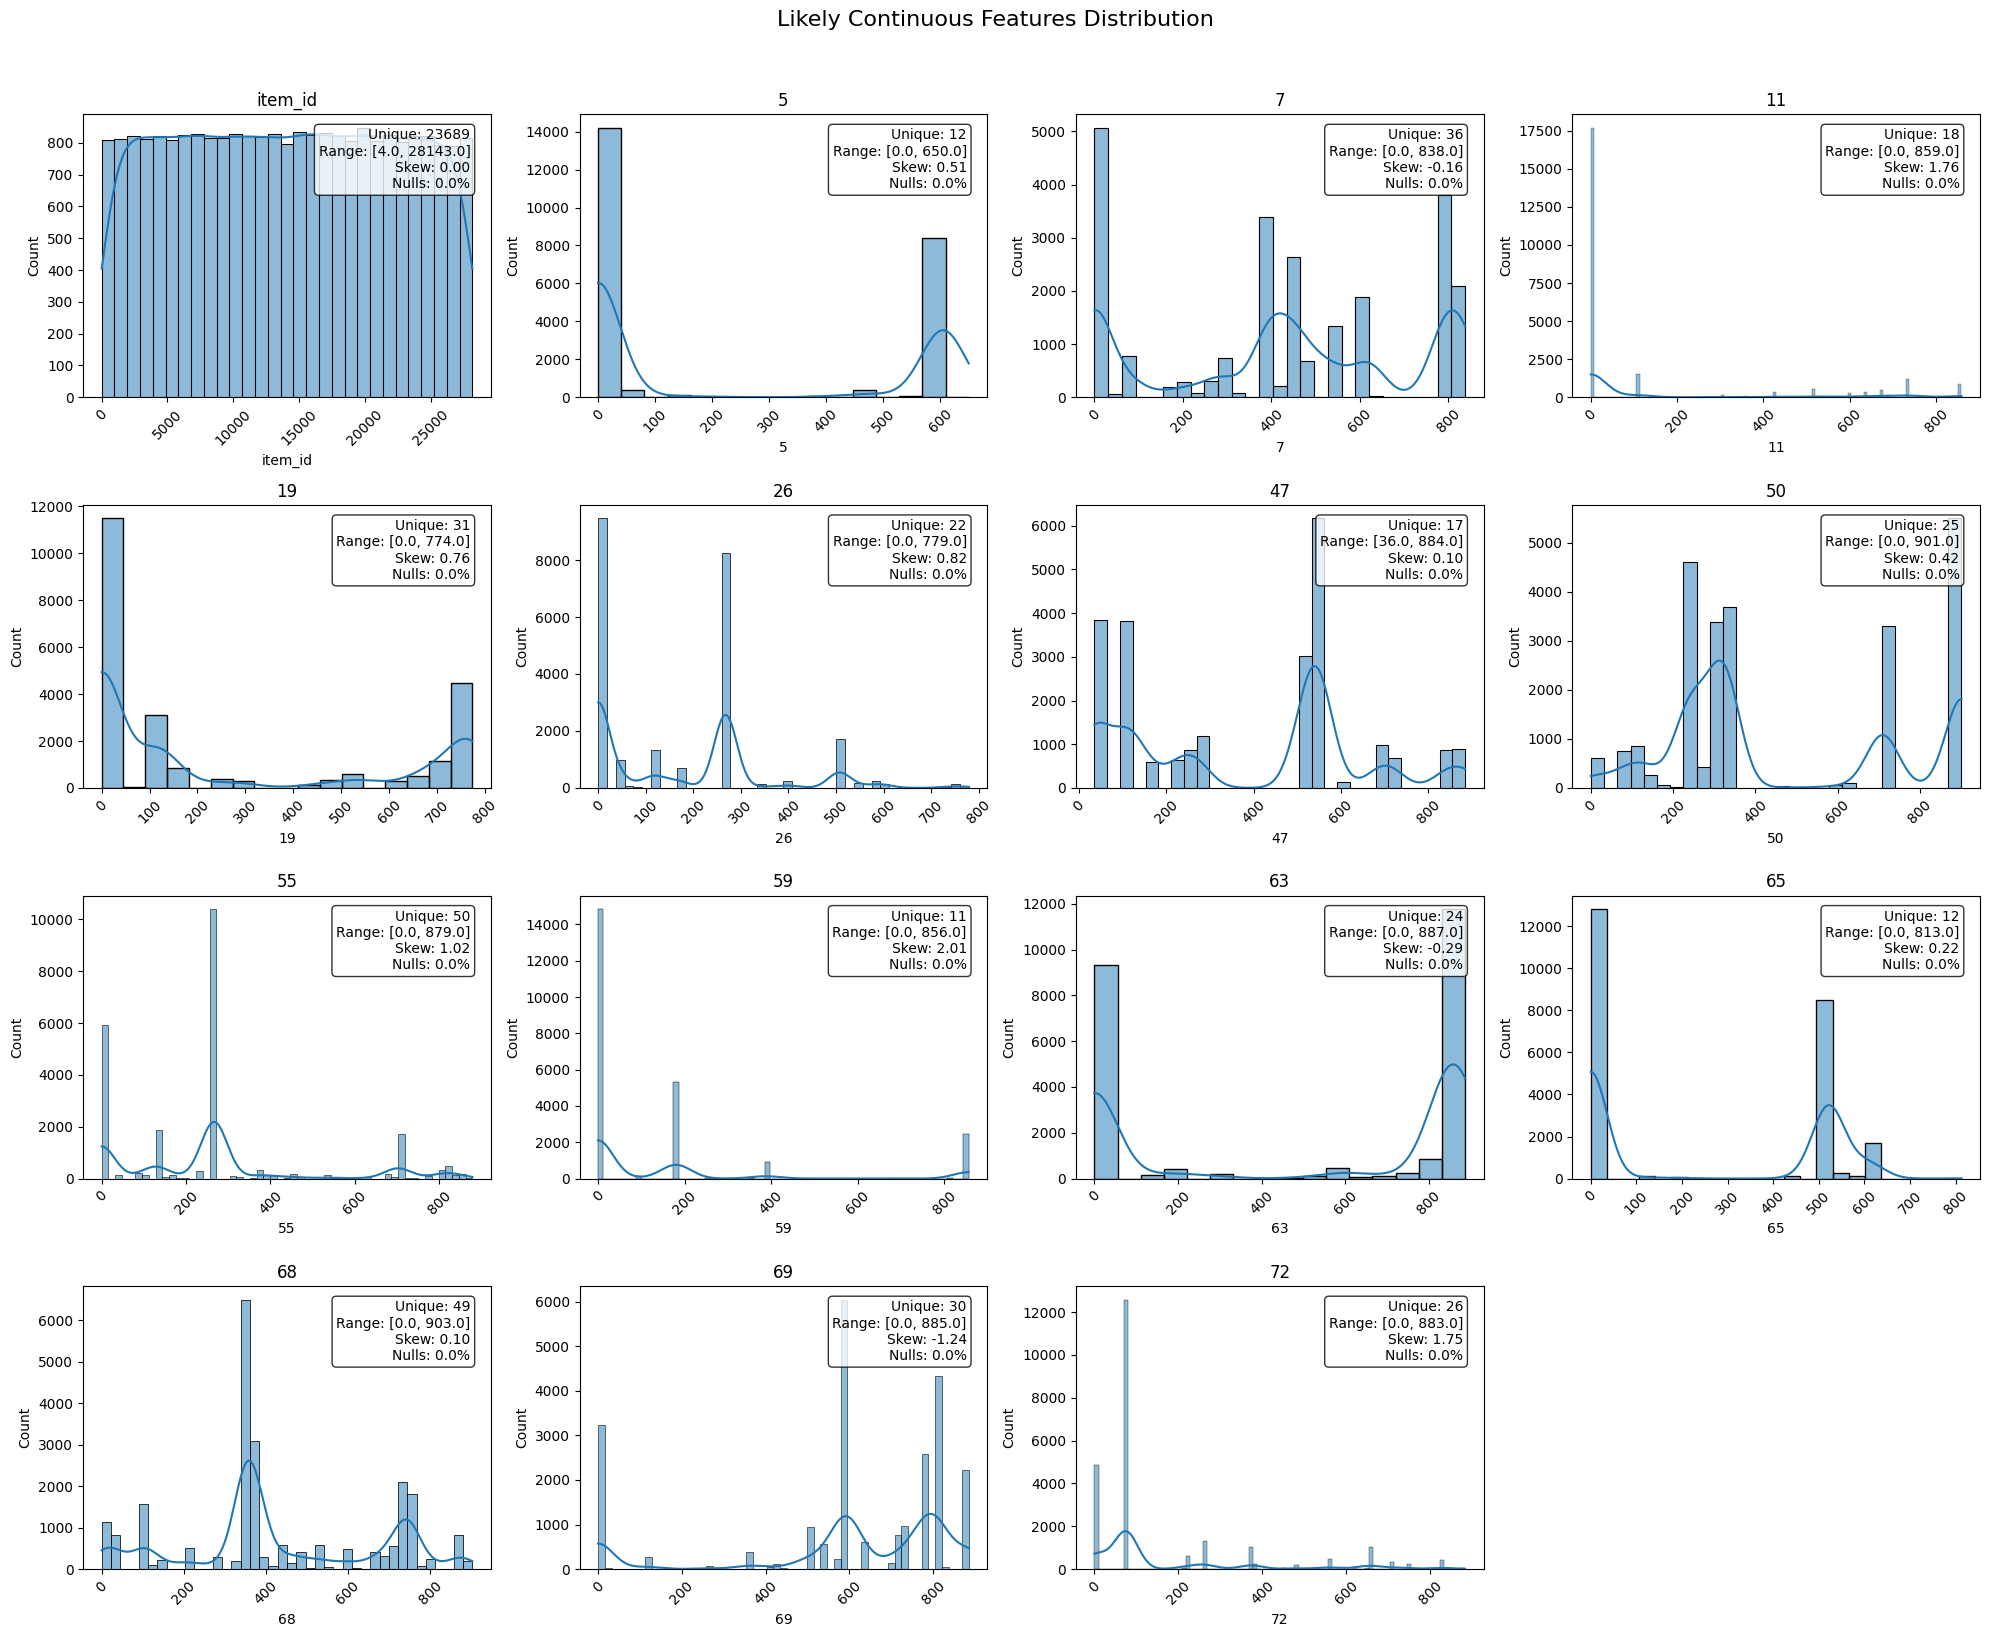

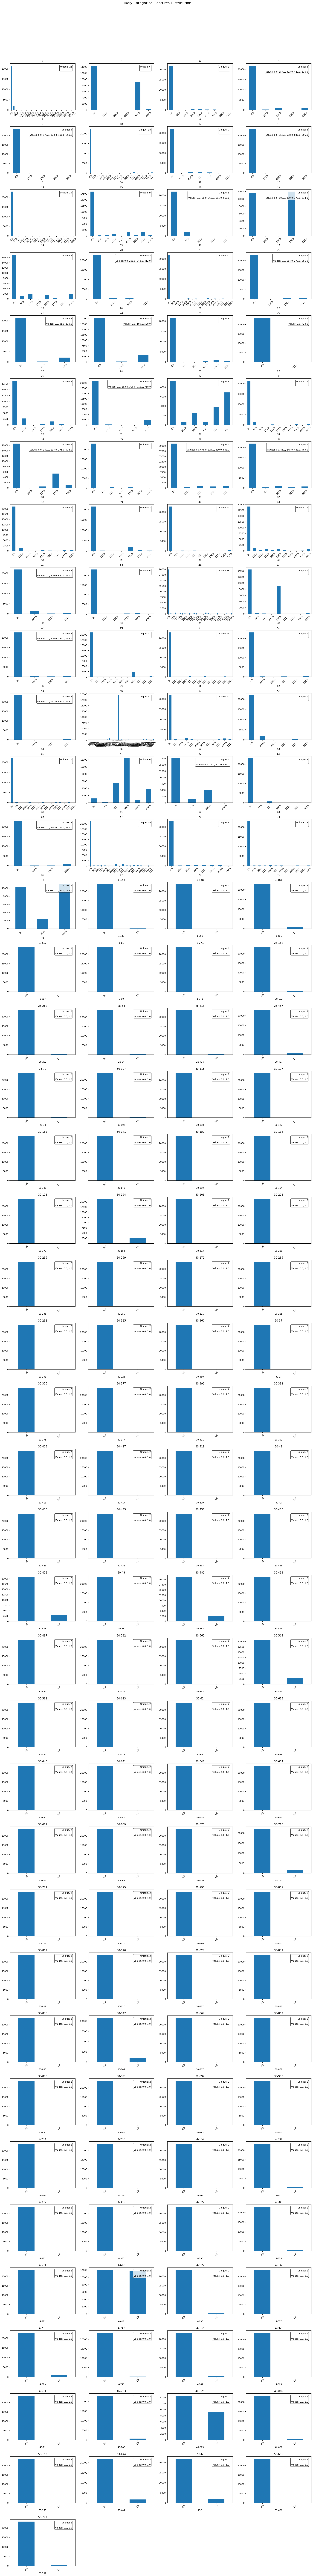

In [37]:
df = features_wide.iloc[2:]
df.columns = df.columns.astype('str')
feature_lists = analyze_numerical_features(df)

# Create and fit the pipeline
pipeline = create_preprocessing_pipeline(
    categorical_features=feature_lists['categorical_features'],
    continuous_features=feature_lists['continuous_features']
)

# Transform your data
transformed_data = pipeline.fit_transform(df)

# Get feature names and convert to DataFrame if needed
feature_names = get_feature_names(pipeline, 
    feature_lists['categorical_features'],
    feature_lists['continuous_features']
)

transformed_df = pd.DataFrame(transformed_data, columns=feature_names)

In [43]:
transformed_df

item_id         5         7        11        19        26        47  \
0     -1.734081  1.309458  1.393176 -0.497964 -0.326389  0.548219 -0.624572   
1     -1.733710 -0.786048  0.366702 -0.497964 -0.686218  0.548219 -1.319168   
2     -1.733587  1.309458  1.260178  2.268858  1.400789  0.548219  0.638677   
3     -1.733464  1.309458  0.366702 -0.087647  1.300662  0.548219  0.638677   
4     -1.733340 -0.786048  1.260178 -0.497964 -0.789473 -0.956009 -1.090180   
...         ...       ...       ...       ...       ...       ...       ...   
23684  1.738136  1.309458  1.260178 -0.497964  1.604170  2.411665 -1.319168   
23685  1.738260 -0.786048 -1.461173 -0.497964 -0.789473 -0.956009  1.291292   
23686  1.738383  1.309458 -1.454352 -0.497964  1.616686  0.548219  1.176798   
23687  1.738507 -0.786048  0.649749 -0.497964 -0.063558  2.361149 -0.532977   
23688  1.738630 -0.786048  1.260178 -0.087647  1.604170  0.548219  0.638677   

             50        55        59  ...  53-155_0.0  53-155_1.0  53-444_0.0  \
0     -0.525930  0.042991  0.131553  ...         1.0         0.0         1.0   
1      0.813264 -1.111899 -0.555578  ...         1.0         0.0         1.0   
2     -0.525930  0.042991  2.712110  ...         1.0         0.0         1.0   
3     -0.525930  1.933203  0.131553  ...         1.0         0.0         1.0   
4     -1.173264 -1.111899 -0.555578  ...         1.0         0.0         1.0   
...         ...       ...       ...  ...         ...         ...         ...   
23684  1.474298  0.042991 -0.555578  ...         1.0         0.0         1.0   
23685 -0.789658  0.042991 -0.555578  ...         1.0         0.0         1.0   
23686 -0.789658  0.042991  0.131553  ...         1.0         0.0         1.0   
23687  0.813264 -1.111899 -0.555578  ...         1.0         0.0         1.0   
23688  0.813264  0.575019  0.131553  ...         1.0         0.0         1.0   

       53-444_1.0  53-6_0.0  53-6_1.0  53-680_0.0  53-680_1.0  53-707_0.0  \
0             0.0       1.0       0.0         1.0         0.0         1.0   
1             0.0       1.0       0.0         1.0         0.0         1.0   
2             0.0       1.0       0.0         1.0         0.0         1.0   
3             0.0       1.0       0.0         1.0         0.0         1.0   
4             0.0       1.0       0.0         1.0         0.0         1.0   
...           ...       ...       ...         ...         ...         ...   
23684         0.0       1.0       0.0         1.0         0.0         1.0   
23685         0.0       1.0       0.0         1.0         0.0         1.0   
23686         0.0       1.0       0.0         1.0         0.0         1.0   
23687         0.0       1.0       0.0         1.0         0.0         1.0   
23688         0.0       1.0       0.0         1.0         0.0         1.0   

       53-707_1.0  
0             0.0  
1             0.0  
2             0.0  
3             0.0  
4             0.0  
...           ...  
23684         0.0  
23685         0.0  
23686         0.0  
23687         0.0  
23688         0.0  

[23689 rows x 725 columns]